# <span style="font-family:Courier New; color:#CCCCCC">**EEUU States Clustering**</span>

<span style="font-family:Courier New">The first component of our Data Models consists in a hierarchical clustering of EEUU states. To carry out this task, it is essential to load the already preprocessed data, and select the variables necessary for the analysis.</span>

In [1]:
# Install dtw module
#%pip install dtaidistance

In [2]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import cophenet
import matplotlib.pyplot as plt
from dtaidistance import dtw
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

## <span style="font-family:Courier New; color:#336666">**Reading Data**</span>

In [3]:
# Read time-series data
df_t = pd.read_csv("../data/preprocessed/dataMatrix/daily_covidMatrix.csv")

n_row, n_col = df_t.shape
print(f"Daily COVID data: {n_row} rows, {n_col} columns")

df_t.sample(5)

Daily COVID data: 18995 rows, 21 columns


,date,state,positive,totalTestResults,death,positiveIncrease,negativeIncrease,total,totalTestResultsIncrease,posNeg,...,hospitalizedIncrease,Dose1_Total,Dose1_Total_pct,Dose1_65Plus,Dose1_65Plus_pct,Complete_Total,Complete_Total_pct,Complete_65Plus,Complete_65Plus_pct,neighbor_contagions
11515,2021-02-19,New Jersey,761498.0,10327680.0,22784.0,3047,63518,10327680,66565,10327680,...,123,1091232.0,12.285619,451587.0,30.614511,460644.0,5.186153,140943.0,9.554972,11817
9537,2020-11-15,Missouri,239451.0,2785399.0,3374.0,3729,4714,1669473,16314,1669473,...,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,30008
8951,2020-04-09,Mississippi,2260.0,20892.0,76.0,257,0,20892,257,20892,...,31,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,2044
12328,2020-04-30,North Carolina,10509.0,139398.0,378.0,561,0,10509,5318,10509,...,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,2000
5441,2020-11-02,Indiana,185185.0,2970330.0,4390.0,3077,9821,1722842,29293,1722842,...,132,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,17079


In [4]:
# Read static strucutral data
df_s = pd.read_csv("../data/preprocessed/dataMatrix/static_stateMatrix.csv")

n_row, n_col = df_s.shape
print(f"Daily COVID data: {n_row} rows, {n_col} columns")

df_s.head()

Daily COVID data: 51 rows, 26 columns


,state,no_coverage,private_coverage,public_coverage,labor_cov_diff,bedsState_local_government,bedsNon_profit,bedsFor_profit,bedsTotal,population_state,...,pop_50-59,pop_60-69,pop_70-79,pop_80+,Low_SVI_CTGY,Moderate_Low_SVI_CTGY,Moderate_High_SVI_CTGY,High_SVI_CTGY,Metro,Non-metro
0,Alabama,10.0,67.3,36.5,5.1,1.4,0.8,0.9,3.1,4887871,...,0.133249,0.120537,0.075243,0.038527,8.99,15.97,43.99,31.04,76.84,23.16
1,Alaska,14.4,65.5,31.0,5.6,0.3,1.5,0.4,2.2,737438,...,0.127204,0.109072,0.050675,0.019748,0.79,83.41,7.29,8.51,67.41,32.59
2,Arizona,10.9,62.8,38.3,2.4,0.1,1.3,0.5,1.9,7171646,...,0.120016,0.113492,0.080306,0.040799,0.00,0.00,66.96,33.04,95.15,4.85
3,Arkansas,9.0,61.5,42.5,1.4,0.3,2.2,0.7,3.2,3013825,...,0.126968,0.115755,0.075878,0.040010,0.83,23.66,36.43,39.08,62.72,37.28
4,California,8.5,63.4,37.2,2.2,0.3,1.2,0.3,1.8,39557045,...,0.126974,0.104040,0.060900,0.035566,1.87,29.21,17.24,51.69,98.11,1.89


## <span style="font-family:Courier New; color:#336666">**Adjusting Data**</span>

### <span style="font-family:Courier New; color:#336633">**Temporal Component**</span>

In [5]:
# Retrieve daily positive increase in cases for each day and state.
df_tPos = df_t.pivot(index='date', columns='state', values='positiveIncrease').fillna(0).sort_index()

# Convert index to datetime
df_tPos.index = pd.to_datetime(df_tPos.index)

# Normalize each state's time series (z-score)
def normalize(series):
    if series.std() == 0:
        return pd.Series(np.zeros_like(series), index=series.index)
    return (series - series.mean()) / series.std()

df_tPos = df_tPos.apply(normalize, axis=0)
df_tPos.sample(5)

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
date,,,,,,,,,,,,,,,,,,,,,
2020-05-14,-0.685992,-0.688567,-0.567725,-0.808401,-0.548837,-0.505632,-0.056027,0.249838,0.592723,-0.823849,...,-0.561882,-0.639101,-0.663098,-0.704587,-0.680061,-0.218308,-0.558137,-0.653965,-0.571293,-0.535059
2020-10-02,-0.192987,0.029334,-0.547252,0.212796,-0.412617,-0.268707,-0.099029,-0.248740,-0.373251,-0.424845,...,0.308508,-0.371523,-0.387767,0.197952,-0.442997,-0.285629,-0.198342,-0.078655,0.724738,0.002778
2020-02-24,-0.972965,-0.714961,-0.760090,-0.891387,-0.724698,-0.776938,-0.540990,-0.866811,-1.094955,-0.997673,...,-0.722077,-0.776225,-0.857103,-0.823633,-0.698297,-0.929509,-0.803228,-0.719650,-0.797627,-0.594312
2020-07-02,-0.033558,-0.514371,0.527365,0.120589,-0.167648,-0.535528,-0.482062,0.043814,-0.817376,1.074605,...,-0.543193,-0.119782,0.203359,-0.312380,-0.388290,-0.574908,0.097729,-0.445585,-0.482915,-0.430226
2020-12-26,-0.129216,1.190646,1.598505,-0.082268,1.915814,0.291841,-0.540990,2.511981,1.947306,2.642970,...,0.391275,5.223451,-0.496158,2.396159,2.675306,0.126294,-0.804209,2.317717,-0.432798,1.602615


In [6]:
# Do the same with hospitilizations
df_tHosp = df_t.pivot(index='date', columns='state', values='hospitalizedIncrease').fillna(0).sort_index()
df_tHosp = df_tHosp.apply(normalize, axis=0)

# And with deaths
df_tDeath = df_t.pivot(index='date', columns='state', values='deathIncrease').fillna(0).sort_index()
df_tDeath = df_tDeath.apply(normalize, axis=0)

### <span style="font-family:Courier New; color:#336633">**Structural Component**</span>

<span style="font-family:Courier New">Most of the variables of static dataset are complementary, for instance metro and non-metro, which have to sum 100%. Thus, the normalization strategy in these features will be to divide by 100, so as to have values in range [0, 1]. </span>

In [7]:
# Normalize variables so as to compute the distances properly
pct_features = ['no_coverage', 'private_coverage', 'public_coverage', 
                'Low_SVI_CTGY', 'Moderate_Low_SVI_CTGY', 'Moderate_High_SVI_CTGY', 'High_SVI_CTGY',
                'Metro', 'Non-metro']
#'pop_0-9', 'pop_10-19', 'pop_20-29', 'pop_30-39', 'pop_40-49', 'pop_50-59', 'pop_60-69', 'pop_70-79', 'pop_80+', -> already in [0, 1]

df_s[pct_features] = df_s[pct_features] / 100

<span style="font-family:Courier New">Normalize with Min-max scaling the other variables. </span>

In [8]:
other_features = ['bedsState_local_government', 'pop_density_state', 'labor_cov_diff', 'population_state',
                  'bedsNon_profit', 'bedsFor_profit', 'bedsTotal']

scaler = MinMaxScaler(feature_range=(0, 1))

scaled_array = scaler.fit_transform(df_s[other_features])
df_s[other_features] = scaled_array

df_s.sample()

,state,no_coverage,private_coverage,public_coverage,labor_cov_diff,bedsState_local_government,bedsNon_profit,bedsFor_profit,bedsTotal,population_state,...,pop_50-59,pop_60-69,pop_70-79,pop_80+,Low_SVI_CTGY,Moderate_Low_SVI_CTGY,Moderate_High_SVI_CTGY,High_SVI_CTGY,Metro,Non-metro
0,Alabama,0.1,0.673,0.365,0.625,0.538462,0.078947,0.692308,0.46875,0.110575,...,0.133249,0.120537,0.075243,0.038527,0.0899,0.1597,0.4399,0.3104,0.7684,0.2316


## <span style="font-family:Courier New; color:#336666">**Compute Distance Matrix**</span>

### <span style="font-family:Courier New; color:#336633">**Temporal Component**</span>

In [9]:
temp_comp = {'positiveIncrease': df_tPos, 
             'hospitalizedIncrease': df_tHosp, 
             'deathIncrease': df_tDeath} # one component for each target variable
DM_comp = dict()

for c_name, c_df in temp_comp.items():

    series = [c_df[state].values for state in c_df.columns]

    # Calculate dtw distances
    condensed_dist = dtw.distance_matrix(series, compact=True, window=30, only_triu=True)

    # Convert to square matrix
    dist_matrix = squareform(condensed_dist)

    # Store distance matrix in dictionary
    DM_comp[c_name] = dist_matrix


# Print an example of distance matrix
states = temp_comp['positiveIncrease'].columns.tolist()
df_tPos_DM = pd.DataFrame(DM_comp['positiveIncrease'], index=states, columns=states)

df_tPos_DM.head()

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Alabama,0.000000,7.834623,8.179305,6.798820,7.356871,8.420551,15.142021,7.992900,12.022739,8.092094,...,10.315355,9.499934,9.321746,8.856883,11.103284,7.355199,11.103474,7.255550,9.082201,10.808480
Alaska,7.834623,0.000000,9.725315,9.024985,8.327533,5.957144,14.115546,8.513078,12.714381,10.640857,...,7.187412,9.131078,11.994531,7.837892,10.323472,9.233377,9.936462,6.504522,6.801519,8.626429
Arizona,8.179305,9.725315,0.000000,8.324013,7.137093,9.353908,13.875115,7.708220,11.131960,7.450437,...,13.443398,8.192792,10.923265,8.085583,11.239524,7.212553,10.459698,7.164162,11.849430,11.575733
Arkansas,6.798820,9.024985,8.324013,0.000000,8.872484,9.431459,14.460021,8.238409,11.479535,8.898678,...,10.951437,9.954380,10.269049,9.018732,11.499951,7.583728,10.953415,7.761335,9.319919,11.474725
California,7.356871,8.327533,7.137093,8.872484,0.000000,6.336740,16.039854,7.067945,11.833424,9.232559,...,13.421606,9.344313,10.823551,8.950866,11.056140,5.212484,12.184466,4.762454,11.830778,11.098787


### <span style="font-family:Courier New; color:#336633">**Structural Component**</span>

In [10]:
# Keep the 'state' variable as index, so as to have a full numerical matrix
df_s.set_index('state', inplace=True)

# Compute pairwise Euclidean distances (condensed form)
condensed_distances = pdist(df_s, metric='euclidean')

# Convert to a square distance matrix
dist_matrix_s = squareform(condensed_distances)

# Convert to DataFrame with state labels
df_s_DM = pd.DataFrame(dist_matrix_s, index=df_s.index, columns=df_s.index)


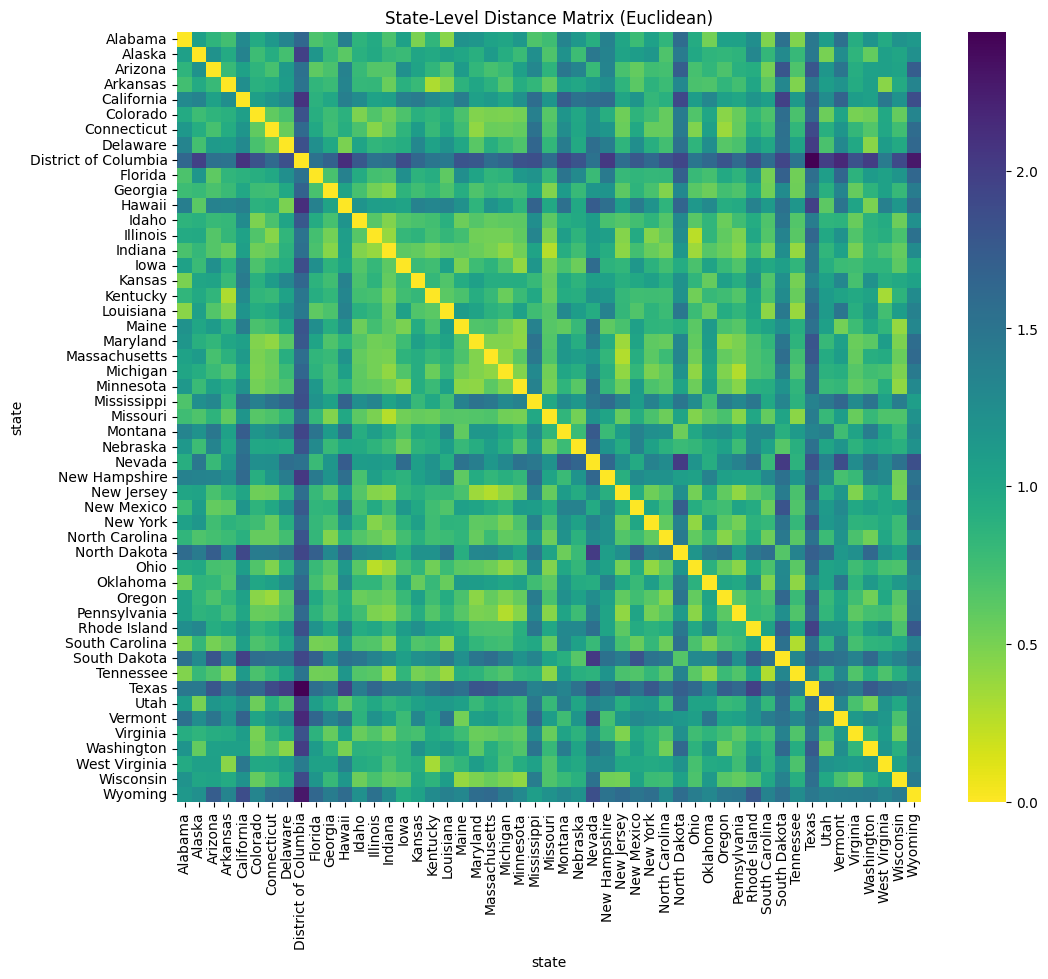

In [11]:
# Visualize the distance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df_s_DM, cmap='viridis_r', annot=False)
plt.title("State-Level Distance Matrix (Euclidean)")
plt.show()

### <span style="font-family:Courier New; color:#336633">**Aggregated Clustering**</span>

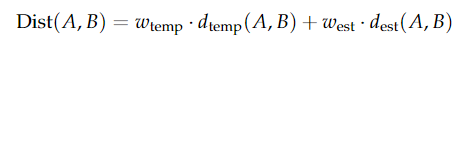
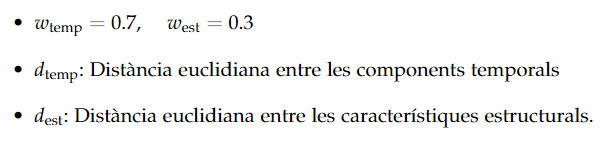

In [71]:
def agg_clustering(temp_comp_DM, temp_comp_name):
    """
    Args:
        temp_comp_DM: distance matrix of a temporal component to perform the aggregtion with structural DM
        temp_comp_name: str representing the temporal component
    """

    # Normalize each matrix to [0, 1]
    scaler = MinMaxScaler()

    w_temp = 0.3; w_est = 0.7

    d_temp_normalized = scaler.fit_transform(temp_comp_DM) # temporal component DM
    d_est_normalized = scaler.fit_transform(dist_matrix_s) # structural DM

    # Combine normalized matrices
    dist_matrix_agg = w_temp * d_temp_normalized + w_est * d_est_normalized

    # Compute linkage matrix (using Ward's method)
    Z = linkage(dist_matrix_agg, method='ward')

    # Cut the dendrogram at distance threshold = 2
    clusters = fcluster(Z, t=1, criterion='distance')

    # Calculate Cophenetic Correlation Coefficient -> original pairwise distances preservation
    coph_dist = cophenet(Z)
    original_dist = pdist(dist_matrix_agg)

    correlation = np.corrcoef(original_dist, coph_dist)[0, 1]
    print(f"Cophenetic Correlation: {correlation:.3f}")
    
    # Map clusters to state labels
    cluster_results = pd.DataFrame({
        'State': states,
        f'Cluster_{temp_comp_name}': clusters
    })

    # Visualize the results
    plt.figure(figsize=(12, 6))
    dendrogram(Z, labels=states, color_threshold=1)
    plt.axhline(y=1, color='b', linestyle='--', label='Cut at distance=2')
    plt.legend()
    plt.title(f"Hierarchical Clustering Dendrogram ({temp_comp_name})")
    plt.xlabel("States")
    plt.ylabel("Distance")
    plt.show()

    return cluster_results

<span style="font-family:Courier New">**Cophenetic Correlation Coefficient (CPCC):** <br>
A value between 0 and 1 that quantifies how faithfully the dendrogram reflects the original distances. A value >0.8 is considered good.</span>

Cophenetic Correlation: 0.766


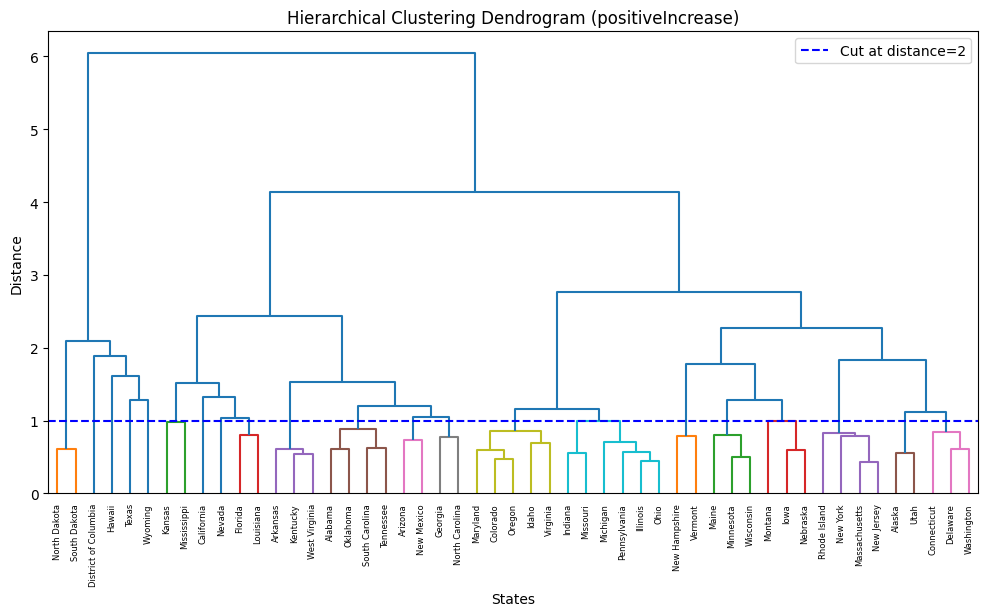

Cophenetic Correlation: 0.766


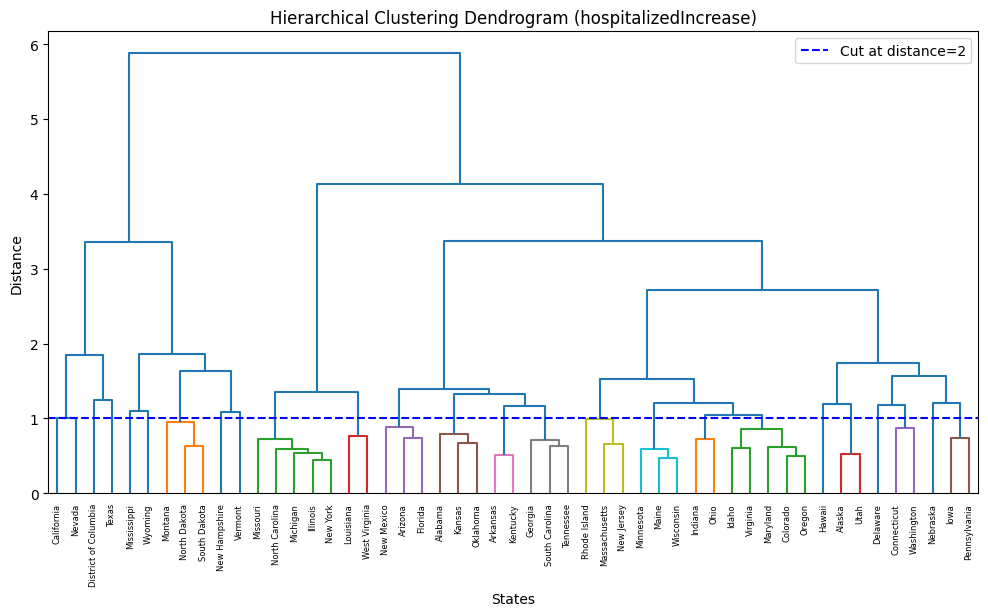

Cophenetic Correlation: 0.750


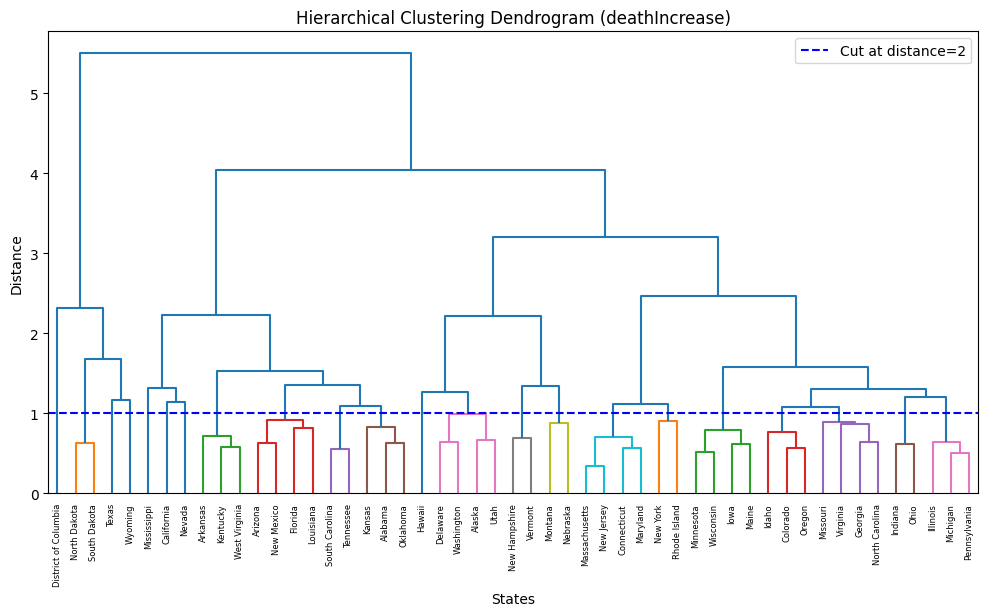

In [72]:
cluster_comp = dict()

for c_name, c_DM in DM_comp.items():
    cluster_comp[c_name] = agg_clustering(c_DM, c_name)

In [73]:
for c_name, clust_df in cluster_comp.items():
    print(f"Nº of clusters for {c_name}: {len(clust_df[f'Cluster_{c_name}'].unique())}")

Nº of clusters for positiveIncrease: 21
Nº of clusters for hospitalizedIncrease: 25
Nº of clusters for deathIncrease: 22


### <span style="font-family:Courier New; color:#336633">**Unifiy Results in a Single df**</span>

In [74]:
# Merge all three results
cluster_df = cluster_comp['positiveIncrease'].merge(cluster_comp['hospitalizedIncrease'], on='State') \
            .merge(cluster_comp['deathIncrease'], on='State')

cluster_df.head()

,State,Cluster_positiveIncrease,Cluster_hospitalizedIncrease,Cluster_deathIncrease
0,Alabama,11,13,11
1,Alaska,20,20,12
2,Arizona,12,12,9
3,Arkansas,10,14,8
4,California,9,1,5


In [ ]:
# Export dataframe
cluster_df.to_csv("state_clusters.csv", index=False)